# Lab Assignment 1: Data Cleaning

In [45]:
%matplotlib inline
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import timeit
import pylab 

import re
import seaborn as sns

#!pip install datacleaner
#def natural_sort(l): 
 #   convert = lambda text: int(text) if text.isdigit() else text.lower() 
 #   alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
 #   return sorted(l, key = alphanum_key)

# Loading and sorting road data

In [46]:
path ='D:\Download\WBSIM_Lab1b\infrastructure\_roads2.csv'

df = pd.read_csv(path,index_col=None, header=0)

df_clean_0 = df#.drop_duplicates(subset=['lon','lat','chainage'], keep=False)

print('Total data before drop duplicates:' ,len(df),'Data')
print('Total data after drop duplicates:' ,len(df_clean_0),'Data')

Total data before drop duplicates: 52210 Data
Total data after drop duplicates: 52210 Data


#  Delete roads with length 1

In [47]:
road_indices = df_clean_0['road'].value_counts().sort_index()
road_indices[(road_indices < 2)]

R316    1
Name: road, dtype: int64

In [48]:
#Find data that have N,R,Z road name
df_N_road = df_clean_0[df_clean_0['road'].str.match('N',case=True, as_indexer=True)]
df_R_road = df_clean_0[df_clean_0['road'].str.match('R',case=True, as_indexer=True)]
df_Z_road = df_clean_0[df_clean_0['road'].str.match('Z',case=True, as_indexer=True)]

# Sort the dataframe based on values
df_N_road.sort_values(by=['road'])
df_R_road.sort_values(by=['road'])
df_Z_road.sort_values(by=['road'])

# Show summary of information data
print('Total N Roads Data:', len(df_N_road))
print('Total R Roads Data:', len(df_R_road))
print('Total Z Roads Data:', len(df_Z_road))
print('Total All Roads Data:', len(df_N_road)+len(df_R_road)+len(df_Z_road))

Total N Roads Data: 9850
Total R Roads Data: 9941
Total Z Roads Data: 32419
Total All Roads Data: 52210


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'as_indexer' keyword was specified but is ignored (match now returns a boolean indexer by default), and will be removed in a future version.
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'as_indexer' keyword was specified but is ignored (match now returns a boolean indexer by default), and will be removed in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 'as_indexer' keyword was specified but is ignored (match now returns a boolean indexer by default), and will be removed in a future version.
  after removing the cwd from sys.path.


In [49]:
# Count the number of data based on the road name ('road')
N_road_data_counts = df_N_road['road'].value_counts().sort_index()
R_road_data_counts = df_R_road['road'].value_counts().sort_index()
Z_road_data_counts = df_Z_road['road'].value_counts().sort_index()

# Count the how many road are there
Unique_N_road = len(N_road_data_counts)
Unique_R_road = len(R_road_data_counts)
Unique_Z_road = len(Z_road_data_counts)

print('There are','[', Unique_N_road,']', 'N roads')
print('There are','[', Unique_R_road,']', 'R roads')
print('There are','[', Unique_Z_road,']', 'Z roads')

There are [ 96 ] N roads
There are [ 125 ] R roads
There are [ 656 ] Z roads


# Loop for detecting errative Lat and Lon values

In [50]:
# create indices matrix
road_indices = []
road_indices.append(N_road_data_counts)
road_indices.append(R_road_data_counts)
road_indices.append(Z_road_data_counts)
road_indices = [y for x in road_indices for y in x]

# set filtering variables
Win       = 20  # size of moving average window
threshold = 3   # maximum allowed strandard deviation difference
maxIter   = 6   # maximum amount of iteration steps allowed per road

# create empty lists
ErLat = []
ErLon = []

# starting endpoint
ep = 0

# define list of errors
outliers = []

# time calculation time
start = timeit.default_timer()

# loop for al N roads
for i in range(len(road_indices)):
    
    # startpoint
    sp = ep
    ep = ep + road_indices[i]
    
    # selecting data
    roadFrame = df_clean_0[sp:ep]
    
    # reset check value
    check = 0
    
    # continuously solving more points
    while (check < maxIter ): # maximum 4 iterations allowed

        # rolling standard deviation of lat and lon
        stdLat = roadFrame['lat'].rolling(window=Win,min_periods=1,center=False).std()
        stdLon = roadFrame['lon'].rolling(window=Win,min_periods=1,center=False).std()

        # moving average
        meanLat = roadFrame['lat'].rolling(window=Win,min_periods=1,center=False).mean()
        meanLon = roadFrame['lon'].rolling(window=Win,min_periods=1,center=False).mean()

        # determine correct values (Boolean)
        ErrorLat = abs(roadFrame['lat'] - meanLat) > threshold * stdLat
        ErrorLon = abs(roadFrame['lon'] - meanLon) > threshold * stdLon

        # determine if dataset is correct or not
        if (sum(ErrorLat) + sum(ErrorLon) == 0): # end while loop 
            check = 100
        else:
            # errorindices
            ErrorIndexLat = roadFrame[ErrorLat].index
            ErrorIndexLon = roadFrame[ErrorLon].index
            
            # append error indices to list
            ErLat.append(ErrorIndexLat)
            ErLon.append(ErrorIndexLon)
            
            # select new dataframe without errative values for next iteration
            roadFrame = roadFrame[(~ErrorLat) & (~ErrorLon)]
            
            # set check counter
            check = check + 1
    
stop = timeit.default_timer()

print(stop-start)

5.963319674721731


In [51]:
def linearly_interpolate_nans(y):
    # Fit a linear regression to the non-nan y values

    # Create X matrix for linreg with an intercept and an index
    X = np.vstack((np.ones(len(y)), np.arange(len(y))))

    # Get the non-NaN values of X and y
    X_fit = X[:, ~np.isnan(y)]
    y_fit = y[~np.isnan(y)].reshape(-1, 1)

    # Estimate the coefficients of the linear regression
    beta = np.linalg.lstsq(X_fit.T, y_fit)[0]

    # Fill in all the nan values using the predicted coefficients
    y.flat[np.isnan(y)] = np.dot(X[:, np.isnan(y)].T, beta)
    
    #bridge['Status'][i] = 'Interchange'
    
    return y

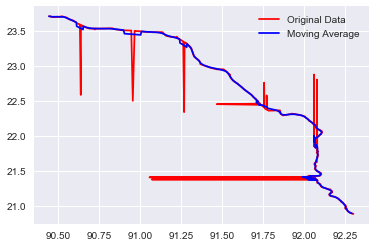

In [52]:
meanLat = df_clean_0[0:1338]['lat'].rolling(window=Win,min_periods=1,center=False).mean()
meanLon = df_clean_0[0:1338]['lon'].rolling(window=Win,min_periods=1,center=False).mean()

#colors = mpl.cm.rainbow(np.linspace(0, 1, len(N_road_data_counts)))
fig, ax = plt.subplots()
ax.plot(df_clean_0[0:1338]['lon'],df_clean_0[0:1338]['lat'],'r',label='Original Data')
ax.plot(meanLon,meanLat,color='b',label='Moving Average')

pylab.legend(loc='upper right')


# Replace errative values with NaN

In [53]:
# create complete list with errors
ErLonList = [y for x in ErLon for y in x]
ErLatList = [y for x in ErLat for y in x]
print('amount of errative longitude values found: ', len(ErLonList))
print('amount of errative lattitude values found: ', len(ErLatList))

# replace errative parts with NaN
df_clean_0.loc[ErLonList,'lon'] = float('NaN')
df_clean_0.loc[ErLatList,'lat'] = float('NaN')

amount of errative longitude values found:  1179
amount of errative lattitude values found:  1194


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'as_indexer' keyword was specified but is ignored (match now returns a boolean indexer by default), and will be removed in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 'as_indexer' keyword was specified but is ignored (match now returns a boolean indexer by default), and will be removed in a future version.
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 'as_indexer' keyword was specified but is ignored (match now returns a boolean indexer by default), and will be removed in a future version.
  """


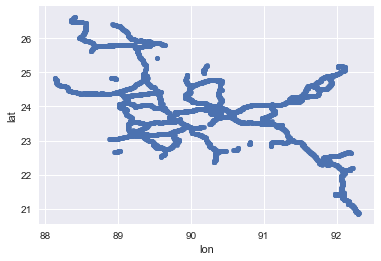

In [54]:
# plot filtered data
#Find data that have N,R,Z road name
df_N_road = df_clean_0[df_clean_0['road'].str.match('N',case=True, as_indexer=True)]
df_R_road = df_clean_0[df_clean_0['road'].str.match('R',case=True, as_indexer=True)]
df_Z_road = df_clean_0[df_clean_0['road'].str.match('Z',case=True, as_indexer=True)]

# Sort the dataframe based on values
df_N_road.sort_values(by=['road'])
df_R_road.sort_values(by=['road'])
df_Z_road.sort_values(by=['road'])


# plot N roads
df_N_road.plot.scatter(x='lon',y='lat')

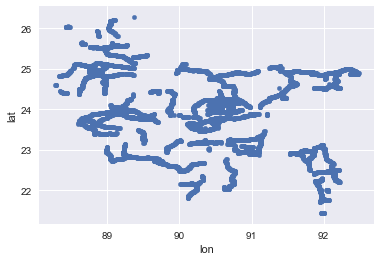

In [30]:
# plot filtered data
df_R_road.plot.scatter(x='lon',y='lat')

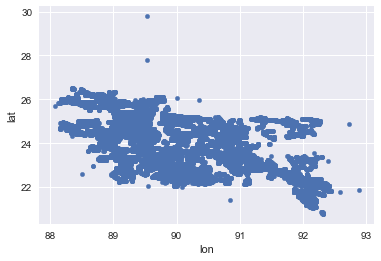

In [31]:
# plot filtered data
df_Z_road.plot.scatter(x='lon',y='lat')

# Save data back to CSV (not finished)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: 'as_indexer' keyword was specified but is ignored (match now returns a boolean indexer by default), and will be removed in a future version.
  # This is added back by InteractiveShellApp.init_path()


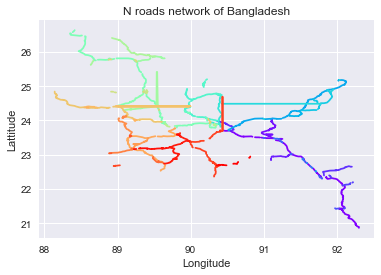

In [55]:
ep = 0
colors = mpl.cm.rainbow(np.linspace(0, 1, len(N_road_data_counts)))
fig, ax = plt.subplots()
for i in range(len(N_road_data_counts)):
    
    # startpoint
    sp = ep
    ep = ep + N_road_data_counts[i]
    
    # selecting data
    df_N_road = df_clean_0[df_clean_0['road'].str.match('N',case=True, as_indexer=True)]
    df_N_road1 = df_N_road[sp:ep]
    #roadFrame = df_clean_0[sp:ep]
    
    # reset check value
    ax.plot(df_N_road1['lon'],df_N_road1['lat'],color=colors[i])
    #df_N_road1.plot(x='lon',y='lat',colours[i])
    #plt.show()
    plt.title('N roads network of Bangladesh')
    plt.xlabel('Longitude')
    plt.ylabel('Lattitude')
    

In [56]:
df_clean_0['Outliers'] = df_clean_0.isnull().any(axis=1)

In [57]:
df_clean_0['Outliers'] = df_clean_0.isnull().any(axis=1)
df_clean_0 = df_clean_0.interpolate()
df_clean_0[df_clean_0['Outliers'] == True].head()

,road,chainage,lrp,lat,lon,type,name,Outliers
69,N1,27.503,LRP027a,23.586222,90.636944,Bridge,Bridge start,True
135,N1,53.269,LRP054,23.521115,90.851389,KmPost,Km post Missing,True
136,N1,54.269,LRP055,23.519063,90.860778,KmPost,Km post Missing,True
137,N1,55.269,LRP056,23.517012,90.869777,KmPost,Km post Missing,True
138,N1,55.333,LRP056a,23.514960,90.870305,Bridge,Bridge start,True


In [58]:
df_clean_0[df_clean_0['Outliers'] == True].head()

,road,chainage,lrp,lat,lon,type,name,Outliers
69,N1,27.503,LRP027a,23.586222,90.636944,Bridge,Bridge start,True
135,N1,53.269,LRP054,23.521115,90.851389,KmPost,Km post Missing,True
136,N1,54.269,LRP055,23.519063,90.860778,KmPost,Km post Missing,True
137,N1,55.269,LRP056,23.517012,90.869777,KmPost,Km post Missing,True
138,N1,55.333,LRP056a,23.514960,90.870305,Bridge,Bridge start,True


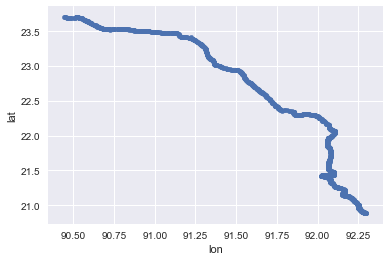

In [59]:
df_clean_0[0:1338].plot.scatter(x='lon',y='lat')

In [60]:


#Convert the dataframe to an XlsxWriter Excel object.
df_clean_0.to_csv('_roads2.csv', encoding='utf-8', index=False)


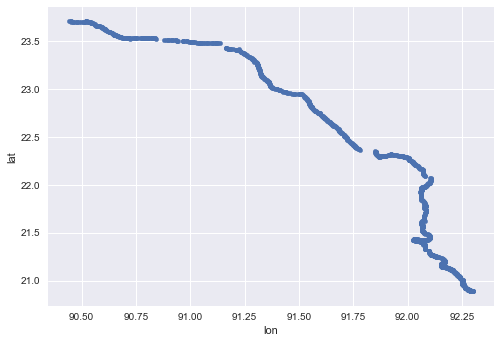

In [19]:
df_N_road[0:1338].plot.scatter(x='lon',y='lat')

In [37]:
dk = pd.DataFrame()
dk = dk.append(df_N_road['road'].value_counts()>100)
dk = dk.transpose()
dk = dk.reset_index()
dk = dk.rename(index=str, columns={"road": "N road > 100","index":"road"})
dk.head()


,road,N road > 100
0,N1,1.0
1,N101,0.0
2,N102,1.0
3,N103,0.0
4,N104,1.0


In [39]:
outliers = []

In [38]:
errors = 3, 4, 5
outliers.append(errors)
print(outliers)

[(3, 4, 5)]


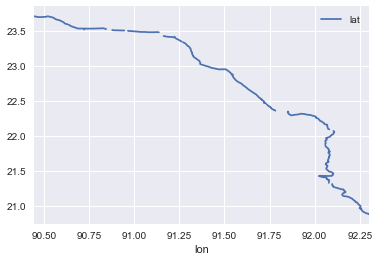

In [40]:
# define start and endpositions
startpoint = 0
endpoint  = 1338
threshold = 4 # amounts of allowed sigma deviation from mean
window    = 20 # size of window for moving average/mean




# create dataframe and plot original data
testframe = df_N_road[startpoint:endpoint]


testframe.plot(x = 'lon', y = 'lat')


## interpolation

In [43]:
# create moving average  matrices
RolMeanLat = pd.rolling_mean(testframe['lat'], window, min_periods = 1)
RolMeanLon = pd.rolling_mean(testframe['lon'], window, min_periods = 1)

# create moving standard deviation matrices
RolStdLat = pd.rolling_std(testframe['lat'], window, min_periods = 1)
RolStdLon = pd.rolling_std(testframe['lon'], window, min_periods = 1)


# boolean for correct values for lon and lat
LatCorrect = abs(testframe['lat'] - RolMeanLat) > threshold * RolStdLat
LonCorrect = abs(testframe['lon'] - RolMeanLon) > threshold * RolStdLon

print(sum(LatCorrect)+sum(LonCorrect))

print(testframe[LatCorrect]['lat'])
print(testframe.loc[LatCorrect,'lat'])

testframe[LatCorrect]['lat'] = float('NaN')
testframe[LonCorrect]['lon'] = float('NaN')


print(testframe[LatCorrect]['lat'])
print(testframe.loc[LatCorrect,'lat'])

# plot correct values
#testframe[LatCorrect & LonCorrect].plot(x = 'lon', y = 'lat')




0
Series([], Name: lat, dtype: float64)
Series([], Name: lat, dtype: float64)
Series([], Name: lat, dtype: float64)
Series([], Name: lat, dtype: float64)


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,min_periods=1,center=False).mean()
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,min_periods=1,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,min_periods=1,center=False).std()
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,min_periods=1,center=False).std()
  import

In [42]:
# repeat operation with cleaned data

newtestframe = testframe[LatCorrect & LonCorrect]

# create moving average  matrices
RolMeanLat = pd.rolling_mean(newtestframe['lat'], window, min_periods = 1)
RolMeanLon = pd.rolling_mean(newtestframe['lon'], window, min_periods = 1)

# create moving standard deviation matrices
RolStdLat = pd.rolling_std(newtestframe['lat'], window, min_periods = 1)
RolStdLon = pd.rolling_std(newtestframe['lon'], window, min_periods = 1)

# boolean for correct values for lon and lat
LatCorrect = abs(newtestframe['lat'] - RolMeanLat) < threshold * RolStdLat
LonCorrect = abs(newtestframe['lon'] - RolMeanLon) < threshold * RolStdLon


# plot correct values
newtestframe[LatCorrect & LonCorrect].plot(x = 'lon', y = 'lat')

print(len(testframe))
print(len(newtestframe))

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,min_periods=1,center=False).mean()
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,min_periods=1,center=False).mean()
  import sys
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,min_periods=1,center=False).std()
  # Remove the CWD from sys.path while we load stuff.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,min_periods=1,center=False).std()
  # This is added back b

TypeError: Empty 'DataFrame': no numeric data to plot

In [ ]:
testframe[65:70].plot(x='lat', y = 'lon')
print(testframe[65:70])

## N roads 

In [ ]:
def mad_based_outlier(points, thresh=2):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh 

In [ ]:
mad_based_outlier(df_N_road[0:100]['lat'])
# Check per 100, but it will be considered as outliers if the "True" data have no series of "True" before and after that. 
# "True series should be greater than 5

In [ ]:
type((df_N_road[0:30]['lat']))
df_N_road.mad()

In [ ]:
initial = 0

for a in range(0, Unique_N_road):
    
    N_road_lat = df_N_road[initial:N_road_data_counts[a]+initial]['lat']
    
    for b in  N_road_lat:
        
        #median = N_road_lat.median()
        #absolute = abs(b-median)
        
        #mad = np.median(absolute)
    
        #print (mad)
        #df_N_road['MAD'] = mad
        
        df_N_road.mad()
    initial = initial+N_road_data_counts[a]

df_N_road.head()

## R roads 

## Z roads 